In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch import nn
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [76]:
data = pd.read_csv('../data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [77]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Volume'] = data['Volume'].astype(float)

In [78]:
x = data.iloc[:, :-1]
y = data.iloc[:, 5:6]

"x values:", x, "y values:", y

('x values:',
                   Open        High         Low       Close   Adj Close
 Date                                                                  
 2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
 2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
 2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
 2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
 2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
 ...                ...         ...         ...         ...         ...
 2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
 2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
 2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
 2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
 2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336
 
 [253 rows x 5 columns],
 'y values:',
         

In [79]:
ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

x_train = x_ss[:200, :]
x_test = x_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", x_train.shape, y_train.shape)
print("Testing Shape", x_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [80]:
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

x_train_tensors_f = torch.reshape(x_train_tensors, (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_test_tensors_f = torch.reshape(x_test_tensors, (x_test_tensors.shape[0], 1, x_test_tensors.shape[1]))

print("Training Shape", x_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [81]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        output, (hn, _) = self.lstm(x, (h_0, c_0))

        hn = hn.view(-1, self.hidden_size)

        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)

        out = self.fc(out)

        return out

In [82]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers, x_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
opti = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
for epoch in range(num_epochs):
    outs = model.forward(x_train_tensors_f)
    opti.zero_grad()
    loss = criterion(outs, y_train_tensors)
    loss.backward()

    opti.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.11005
Epoch: 100, loss: 0.04272
Epoch: 200, loss: 0.03917
Epoch: 300, loss: 0.03913
Epoch: 400, loss: 0.03910
Epoch: 500, loss: 0.03907
Epoch: 600, loss: 0.03903
Epoch: 700, loss: 0.03898
Epoch: 800, loss: 0.03890
Epoch: 900, loss: 0.03879


In [84]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, 5:6])

df_x_ss = torch.Tensor(df_x_ss)
df_y_ms = torch.Tensor(df_y_ms)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

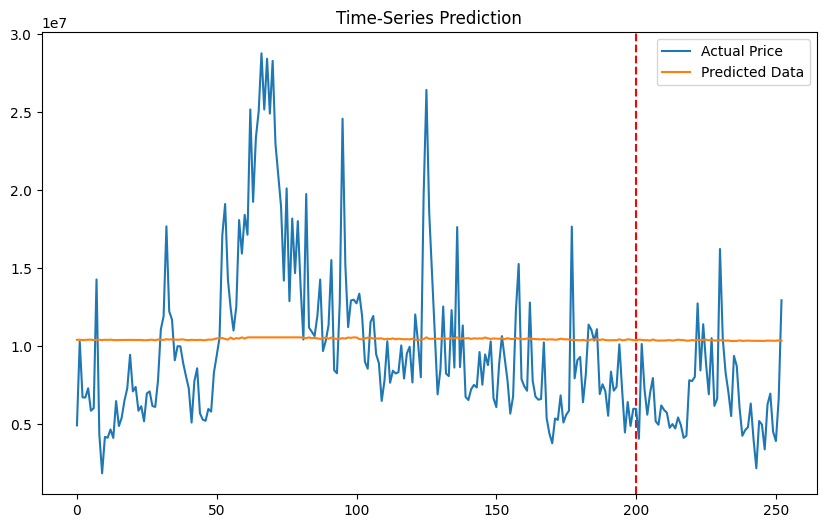

In [85]:
train_predict = model(df_x_ss)
predicted = train_predict.detach().numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label="Actual Price")
plt.plot(predicted, label="Predicted Data")
plt.title("Time-Series Prediction")
plt.legend()
plt.show()